In [1]:
import json, os, re, shutil, sys, time, csv
import collections, itertools

# NLTK for NLP utils and corpora
import nltk
assert(nltk.download('gutenberg'))

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, rnnlm


[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/sharmila_velamur/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
canonicalized_words = []
indir = '../preprocess/'
books = []
for root, dirs, filenames in os.walk(indir):
    for filename in filenames:
        if filename.startswith('canonicalized_words_'):
            with open(indir+filename, 'r') as f:
                for line in f.readlines():
                    w = line.rstrip()
                    if w != '':
                        canonicalized_words.append(w)
num_words = len(canonicalized_words)
print num_words
print canonicalized_words[0:10]
print canonicalized_words[num_words-10:num_words]

163612941
['lincoln', "'s", 'first', 'inaugural', 'address', 'march', 'DG', ',', 'DGDGDGDG', 'fellow']
['wings', 'speeded', 'like', 'thought', 'upon', 'the', 'light', 'of', 'heaven', '.']


In [3]:
from collections import Counter
import operator

tokens = Counter()
for w in canonicalized_words:
    tokens[w] += 1
tokens = sorted(tokens.items(), key=operator.itemgetter(1), reverse=True)

print "Total Tokens: ", len(canonicalized_words)
print "Total Types: ", len(tokens)

Total Tokens:  163612941
Total Types:  427233


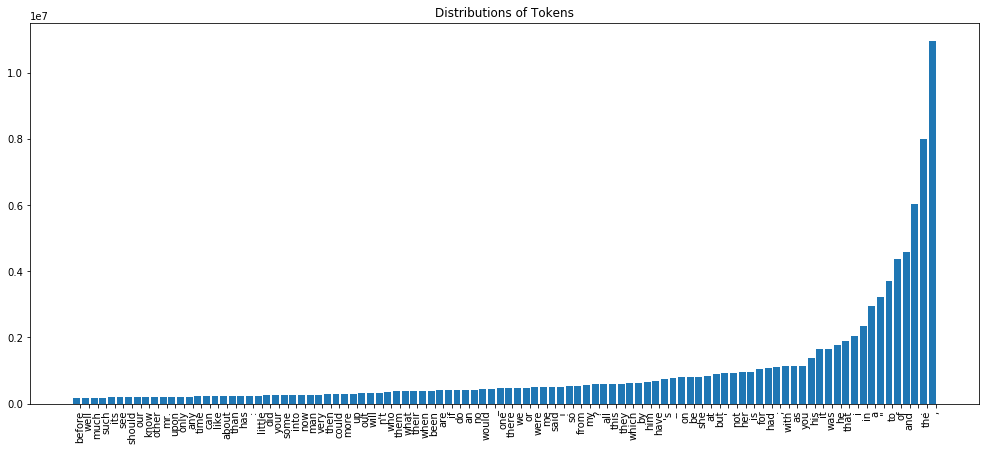

In [6]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[0:100]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()


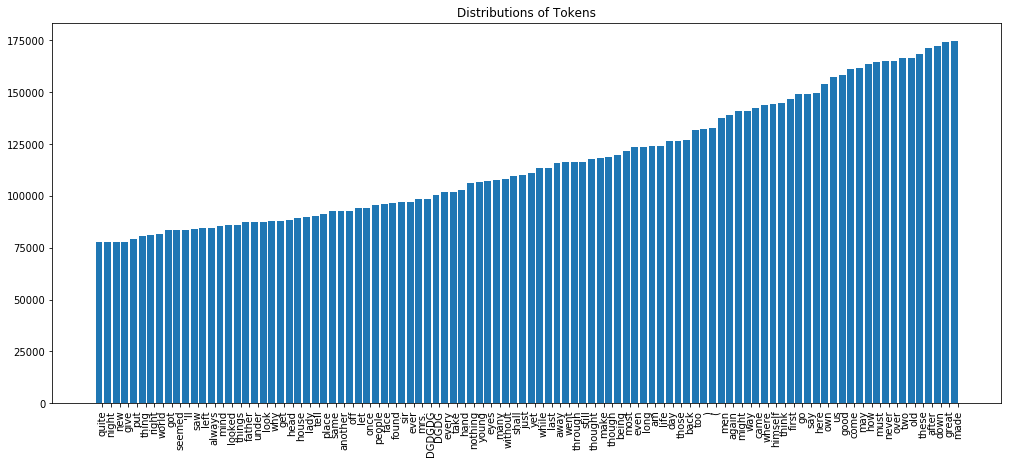

In [7]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[100:200]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()

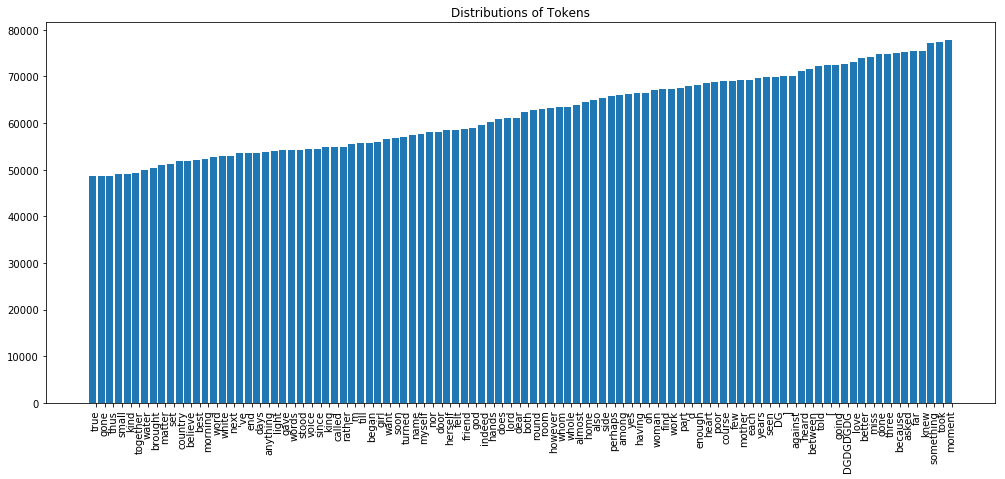

In [8]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[200:300]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()

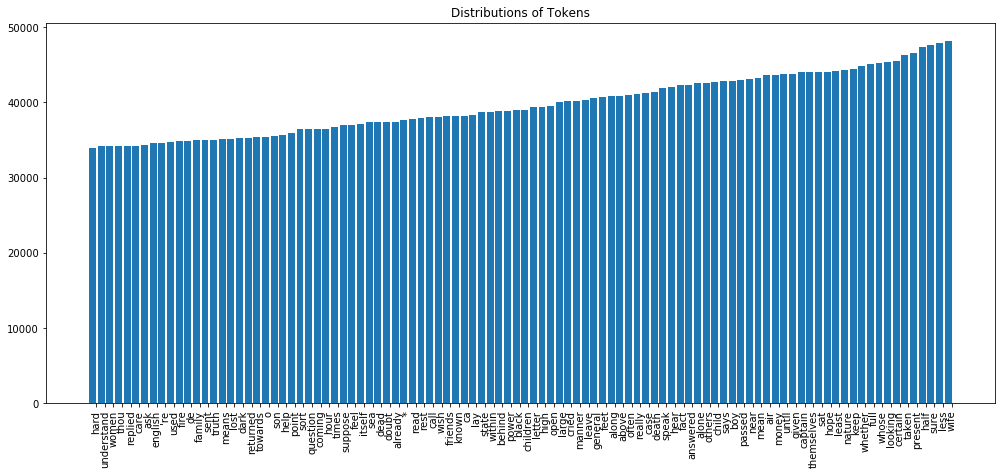

In [9]:
# the histogram of the data
%matplotlib inline
import matplotlib.mlab as mlab
import pylab as pl
import matplotlib.pyplot as plt

results = tokens[300:400]
    
items = (np.array(results)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of Tokens")
pl.show()

We see the counts are very high for punctuations. There are two options to try:
1. Remove the punctuations and expand contractions.
2. Remove the punctuations but do not expand contractions.
3. Break sentence at punctuations [meaningful phrases].

In [11]:
tokens[0:10]

[(',', 10972442),
 ('the', 8023153),
 ('.', 6056456),
 ('and', 4574772),
 ('of', 4374737),
 ('to', 3710837),
 ('"', 3230860),
 ('a', 2948180),
 ('in', 2359086),
 ('i', 2047810)]

In [23]:
## Generate the vocabulary
V = 10000
vocab = vocabulary.Vocabulary((w for w in words), size=V)

In [24]:
sents = []
indir = '../preprocess/'
books = []
for root, dirs, filenames in os.walk(indir):
    for filename in filenames:
        if filename.startswith('parsed_sents_'):
            with open(indir+filename, 'r') as f:
                for line in f.readlines():
                    sents.append(line.rstrip())
num_sents = len(sents)
print num_sents
print sents[num_sents-10:num_sents]

9494082
['<s> FOR SALE WHEREVER BOOKS ARE SOLD . </s>', '<s> J. S. OGILVIE PUBLISHING COMPANY 57 Rose Street , New York OGILVIE \'S POPULAR COPYRIGHT LINE THE PEER AND THE WOMAN BY E. PHILLIPS OPPENHEIM AUTHOR OF " A MONK OF CRUTA , " " THE MISSIONER , " ETC . </s>', '<s> _ One of the Most Popular Authors of the present day . </s>', '<s> _ * * * * * A story of romance , mystery , and adventure , in which , as in many mystery stories , there is the adventuress , with whom , for some reason , the peer , notwithstanding his breeding and social position , becomes entangled , until he is mysteriously put out of the way . </s>', '<s> From this point on complication and adventure succeed each other in rapid succession , holding the reader in rapt fascination until the end of the story is reached , where the plots of love and mysterious disappearances are surprisingly unfolded . </s>', "<s> This story has been written in Mr. Oppenheim 's most entertaining and interesting style , and will be ap

In [25]:
corpus = np.array(list(sents), dtype=object)
print len(corpus)

9494082


In [26]:
def preprocess_sentences(sentences, vocab):
    """Preprocess sentences by canonicalizing and mapping to ids.

    Args:
      sentences ( list(list(string)) ): input sentences
      vocab: Vocabulary object, already initialized

    Returns:
      ids ( array(int) ): flattened array of sentences, including boundary <s>
      tokens.
    """
    # Add sentence boundaries, canonicalize, and handle unknowns
    words = (s for s in sentences)
    words = [utils.canonicalize_word(w, wordset=vocab.word_to_id)
             for w in words]
    return np.array(vocab.words_to_ids(words))

split=0.8 
shuffle=True

"""Get train and test sentences.

Args:
  corpus: sentences parsed from the Gutenberg Contemporary Authors corpus
  split (double): fraction to use as training set
  shuffle (int or bool): seed for shuffle of input data, or False to just
  take the training data as the first xx% contiguously.
  train_sentences, test_sentences ( list(list(string)) ): the train and test splits
"""

sentences = np.array(corpus, dtype=object)
fmt = (len(sentences), sum(map(len, sentences)))
print "Loaded %d sentences (%g tokens)" % fmt

if shuffle:
    rng = np.random.RandomState(shuffle)
    rng.shuffle(sentences)  # in-place
train_frac = 0.8
split_idx = int(train_frac * len(sentences))
train_sentences = sentences[:split_idx]
test_sentences = sentences[split_idx:]

fmt = (len(train_sentences), sum(map(len, train_sentences)))
print "Training set: %d sentences (%d tokens)" % fmt
fmt = (len(test_sentences), sum(map(len, test_sentences)))
print "Test set: %d sentences (%d tokens)" % fmt

## convert words to ids based on the vocab wordset created above
train_ids = preprocess_sentences(train_sentences, vocab)
test_ids = preprocess_sentences(test_sentences, vocab)


Loaded 9494082 sentences (1.10435e+09 tokens)
Training set: 7595265 sentences (883446998 tokens)
Test set: 1898817 sentences (220906362 tokens)


In [27]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = False
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        feed_dict = {lm.input_w_: w, lm.target_y_: y, lm.initial_h_: h}
        ## print "Calling computational graph"
        cost, train_op_ = session.run([loss, train_op], feed_dict)
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time
        

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [28]:
def score_dataset(lm, session, ids, name="Data"):
    # For scoring, we can use larger batches to speed things up.
    bi = utils.batch_generator(ids, batch_size=100, max_time=100)
    cost = run_epoch(lm, session, bi, 
                     learning_rate=1.0, train=False, 
                     verbose=False, tick_s=3600)
    print "%s: avg. loss: %.03f  (perplexity: %.02f)" % (name, cost, np.exp(cost))

In [30]:
max_time = 50
batch_size = 20
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=vocab.size, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=3)

TF_SAVEDIR = "tf_saved"
checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [31]:
# Will print status every this many seconds
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils.batch_generator(train_ids, batch_size, max_time)
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        
        run_epoch(lm, session, bi,
              train=True, verbose=True,
              tick_s=10, learning_rate=0.1)
        
        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    ##
    # score_dataset will run a forward pass over the entire dataset
    # and report perplexity scores. This can be slow (around 1/2 to 
    # 1/4 as long as a full epoch), so you may want to comment it out
    # to speed up training on a slow machine. Be sure to run it at the 
    # end to evaluate your score.
    print ("[epoch %d]" % epoch),
    score_dataset(lm, session, train_ids, name="Train set")
    print ("[epoch %d]" % epoch),
    score_dataset(lm, session, test_ids, name="Test set")
    print ""
    # Save final model
    saver.save(session, trained_filename)

[epoch 1] Starting epoch 1
[batch 39]: seen 40000 words at 3930 wps, loss = 0.733
[batch 79]: seen 80000 words at 3942 wps, loss = 0.404
[batch 119]: seen 120000 words at 3930 wps, loss = 0.283
[batch 159]: seen 160000 words at 3947 wps, loss = 0.217
[batch 199]: seen 200000 words at 3945 wps, loss = 0.175
[batch 239]: seen 240000 words at 3953 wps, loss = 0.146
[batch 279]: seen 280000 words at 3952 wps, loss = 0.126
[batch 320]: seen 321000 words at 3962 wps, loss = 0.110
[batch 360]: seen 361000 words at 3963 wps, loss = 0.098
[batch 401]: seen 402000 words at 3969 wps, loss = 0.088
[batch 442]: seen 443000 words at 3979 wps, loss = 0.080
[batch 483]: seen 484000 words at 3982 wps, loss = 0.073
[batch 524]: seen 525000 words at 3986 wps, loss = 0.068
[batch 565]: seen 566000 words at 3993 wps, loss = 0.063
[batch 606]: seen 607000 words at 3999 wps, loss = 0.059
[batch 647]: seen 648000 words at 3998 wps, loss = 0.055
[batch 687]: seen 688000 words at 3997 wps, loss = 0.052
[batch 7

In [32]:
def score_seq(lm, session, seq, vocab):
    """Score a sequence of words. Returns total log-probability."""
    padded_ids = vocab.words_to_ids(utils.canonicalize_words(["<s>"] + seq + ["</s>"], 
                                                             wordset=vocab.word_to_id))
    w = np.reshape(padded_ids[:-1], [1,-1])
    y = np.reshape(padded_ids[1:],  [1,-1])
    h = session.run(lm.initial_h_, {lm.input_w_: w})
    feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.initial_h_:h,
                 lm.dropout_keep_prob_: 1.0}
    # Return log(P(seq)) = -1*loss
    return -1*session.run(lm.loss_, feed_dict)

def load_and_score(inputs, sort=False):
    """Load the trained model and score the given words."""
    lm = rnnlm.RNNLM(**model_params)
    lm.BuildCoreGraph()
    
    with lm.graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=lm.graph) as session:  
        # Load the trained model
        saver.restore(session, trained_filename)

        if isinstance(inputs[0], str) or isinstance(inputs[0], unicode):
            inputs = [inputs]

        # Actually run scoring
        results = []
        for words in inputs:
            score = score_seq(lm, session, words, vocab)
            results.append((score, words))

        # Sort if requested
        if sort: results = sorted(results, reverse=True)

        # Print results
        for score, words in results:
            print "\"%s\" : %.02f" % (" ".join(words), score)

In [33]:
sents = ["i shall be miserable if i have not an excellent library",
         "to be fond of dancing was a certain step towards falling in love",
         "don't let the door hit you on your way out",
         "he was totally into it",
         "to be or not to be",
         "come on y'all, don't be like that!",
         "get outta here",
        "the market dropped significantly today",
        "i do not fear computers, i fear the lack of them"]
load_and_score([s.split() for s in sents])

INFO:tensorflow:Restoring parameters from tf_saved/rnnlm_trained
"i shall be miserable if i have not an excellent library" : -3.44
"to be fond of dancing was a certain step towards falling in love" : -2.95
"don't let the door hit you on your way out" : -3.75
"he was totally into it" : -6.78
"to be or not to be" : -5.84
"come on y'all, don't be like that!" : -5.13
"get outta here" : -13.50
"the market dropped significantly today" : -6.78
"i do not fear computers, i fear the lack of them" : -3.44
